# Retrieval-Augmented Generation (RAG) Evaluation Harness  
**Candidate:** Crystal Ford  
**Target Role:** Data Scientist II — Microsoft (M365 Core)  
**GitHub:** [github.com/crystalmford](https://github.com/crystalmford)  
**LinkedIn:** [linkedin.com/in/crystalmford](https://www.linkedin.com/in/crystalmford)  
**Email:** crystalmford@gmail.com

## Executive Summary  
## Executive Summary  
This project shows how to build and evaluate a small retrieval-augmented generation (RAG) system from end to end.  
The system takes a question, searches a small knowledge base for the most relevant information, and then uses a language model to write an answer based only on what it found.  

It includes tools to check how well the system is working, like measuring how accurate and relevant its answers are, how well they match the supporting documents, and how often it admits when it doesn’t know something.  
There’s also a way to experiment with how much context the model sees at once, plus features that flag weak answers and catch performance drops over time.  

The goal is to give a clear, lightweight framework for testing and improving RAG systems that is simple enough to run quickly, but structured enough to trust the results.

## How to Run  
1. **Open in a Python environment**  
   This notebook runs on Google Colab or any Python environment with GPU support.

2. **Install the required libraries**  
   The first cell automatically installs everything needed:  
   `sentence-transformers`, `faiss-cpu`, `transformers`, `accelerate`, and `torch`.

3. **Run cells in order (Parts 1–14)**  
   Each part builds on the last:
   - Parts 1–5: Create and prepare the data  
   - Parts 6–10: Evaluate and analyze performance  
   - Parts 11–14: Add quality checks and export results

4. **Review the outputs**  
   - Check the metrics table, composite score, and summary table  
   - Review flagged answers to see where the system struggled  
   - Open the exported CSVs and README file for a portable copy of the results

Running the full notebook from start to finish typically takes just a few minutes.

## Part 1: Setup  
This section installs the required libraries and configures the environment.  
Random seeds are set for reproducibility, ensuring results stay consistent across different runs and machines.


In [1]:
# Part 1: Lightweight installs (run once per environment)
# If you're in an environment that already has these, you can skip installs.

!pip -q install sentence-transformers faiss-cpu transformers accelerate torch --upgrade

In [2]:
# Part 1: Imports & utility setup

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import numpy as np
import faiss
import pandas as pd
import textwrap
import re
from typing import List, Dict, Tuple

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

## Part 2: Build a Mini Knowledge Base  
A small, domain-specific knowledge base is created to simulate a company wiki.  
Each document contains short factual content and is split into overlapping chunks so the retriever can match focused sections instead of full documents.


In [3]:
# Part 2: Tiny domain-specific knowledge base (you can edit/expand freely)

RAW_DOCS = [
    {
        "doc_id": "kb_001",
        "title": "Copilot Notebooks: Overview",
        "text": """Copilot Notebooks are intelligent, dynamic notebooks that combine freeform text,
structured cells, and AI assistance. They help users summarize notes, extract action items,
and draft content. Users can reference prior notebook cells, files, or links. Privacy is enforced
via tenant boundaries and role-based access."""
    },
    {
        "doc_id": "kb_002",
        "title": "Retrieval-Augmented Generation (RAG) Basics",
        "text": """RAG systems retrieve relevant context from a knowledge base and feed it to a language model.
This improves factuality and reduces hallucination. Key steps: embed documents, index vectors,
search by similarity, and condition the model with retrieved context."""
    },
    {
        "doc_id": "kb_003",
        "title": "Evaluation Metrics for RAG",
        "text": """Useful evaluation axes include Relevance (did we retrieve the right passages?),
Faithfulness (does the answer stick to the provided context?), and Helpfulness (is the answer clear and actionable?).
Lightweight proxies include semantic similarity, context overlap, and simple exact-match checks."""
    },
    {
        "doc_id": "kb_004",
        "title": "Data Privacy & Responsible AI",
        "text": """Responsible AI principles prioritize privacy, security, fairness, and transparency.
For notebooks, restrict sensitive data, log accesses, and ensure human oversight.
When evaluating models, record prompts, contexts, and outputs for traceability."""
    },
    {
        "doc_id": "kb_005",
        "title": "OneNote Shortcuts & Tips",
        "text": """OneNote supports keyboard shortcuts for faster note-taking. Common tasks include adding headings,
creating checklists, and inserting meeting details. Users can tag notes, sync across devices,
and collaborate in shared notebooks."""
    },
]
len(RAW_DOCS)

5

In [4]:
# Part 2: Text chunking helper
def chunk_text(text: str, chunk_size: int = 400, overlap: int = 60) -> List[str]:
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
        i += chunk_size - overlap
    return chunks

# Build a flat list of chunks with metadata
DOC_CHUNKS = []
for doc in RAW_DOCS:
    chunks = chunk_text(doc["text"], chunk_size=120, overlap=25)
    for idx, chunk in enumerate(chunks):
        DOC_CHUNKS.append({
            "doc_id": doc["doc_id"],
            "title": doc["title"],
            "chunk_id": f'{doc["doc_id"]}_{idx:02d}',
            "text": chunk
        })

len(DOC_CHUNKS), DOC_CHUNKS[0]

(5,
 {'doc_id': 'kb_001',
  'title': 'Copilot Notebooks: Overview',
  'chunk_id': 'kb_001_00',
  'text': 'Copilot Notebooks are intelligent, dynamic notebooks that combine freeform text, structured cells, and AI assistance. They help users summarize notes, extract action items, and draft content. Users can reference prior notebook cells, files, or links. Privacy is enforced via tenant boundaries and role-based access.'})

## Part 3: Embeddings and Retriever  
Each text chunk is converted into a semantic vector using a sentence-transformer model.  
These vectors are stored in a FAISS index for efficient similarity search, enabling the system to retrieve the most relevant chunks based on meaning rather than keywords.

In [5]:
# Part 3: Load embedding model (small & fast)
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBEDDING_MODEL_NAME, device=DEVICE)

# Compute embeddings for all chunks
EMB_DIM = embedder.get_sentence_embedding_dimension()
vectors = embedder.encode([c["text"] for c in DOC_CHUNKS], convert_to_numpy=True, show_progress_bar=True)
vectors.shape, EMB_DIM

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

((5, 384), 384)

In [6]:
# Part 3: Build FAISS index
index = faiss.IndexFlatIP(EMB_DIM)  # inner product (cosine if vectors are normalized)
# Normalize for cosine similarity equivalence
norms = np.linalg.norm(vectors, axis=1, keepdims=True) + 1e-12
vectors_norm = vectors / norms
index.add(vectors_norm.astype('float32'))

# Store an ID map so we can get chunks back
ID2CHUNK = {i: DOC_CHUNKS[i] for i in range(len(DOC_CHUNKS))}
len(ID2CHUNK)

5

In [7]:
# Part 3: Simple retriever (safe & cosine-correct)

def retrieve(query: str, k: int = 4) -> List[Dict]:
    """
    Retrieves up to k most similar chunks by cosine similarity.
    - Caps k to the number of indexed vectors (avoids FAISS -1 pads)
    - Skips any -1 indices just in case
    """
    # No vectors indexed yet
    if index.ntotal == 0:
        return []

    # Never ask for more neighbors than exist
    k_eff = min(k, index.ntotal)

    # Embed and L2-normalize query for cosine/IP equivalence
    q_vec = embedder.encode([query], convert_to_numpy=True)
    q_vec = q_vec / (np.linalg.norm(q_vec, axis=1, keepdims=True) + 1e-12)
    q_vec = q_vec.astype("float32")

    # FAISS search
    D, I = index.search(q_vec, k_eff)

    # Collect results, skipping FAISS pad values (-1)
    results = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0:
            continue
        ch = ID2CHUNK[int(idx)].copy()
        ch["score"] = float(score)
        results.append(ch)
    return results

# Quick smoke test
retrieve("How does RAG reduce hallucinations?", k=3)

[{'doc_id': 'kb_002',
  'title': 'Retrieval-Augmented Generation (RAG) Basics',
  'chunk_id': 'kb_002_00',
  'text': 'RAG systems retrieve relevant context from a knowledge base and feed it to a language model. This improves factuality and reduces hallucination. Key steps: embed documents, index vectors, search by similarity, and condition the model with retrieved context.',
  'score': 0.37860313057899475},
 {'doc_id': 'kb_001',
  'title': 'Copilot Notebooks: Overview',
  'chunk_id': 'kb_001_00',
  'text': 'Copilot Notebooks are intelligent, dynamic notebooks that combine freeform text, structured cells, and AI assistance. They help users summarize notes, extract action items, and draft content. Users can reference prior notebook cells, files, or links. Privacy is enforced via tenant boundaries and role-based access.',
  'score': 0.003209097310900688},
 {'doc_id': 'kb_003',
  'title': 'Evaluation Metrics for RAG',
  'chunk_id': 'kb_003_00',
  'text': 'Useful evaluation axes include Rel

## Part 4: Generation with Retrieved Context  
A FLAN-T5 model generates answers using the retrieved chunks as context.  
A custom function retrieves top-matching chunks, builds a structured prompt, and instructs the model to respond only using the provided context to reduce hallucination.

In [8]:
# Part 4: Load generator (FLAN-T5 base) and tokenizer
GEN_MODEL_NAME = "google/flan-t5-base"
gen_tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL_NAME)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL_NAME).to(DEVICE)

def _format_context(chunks: List[Dict], max_chars: int = 1400) -> str:
    """Concatenate retrieved chunks with sources, capped by character budget."""
    parts = []
    total = 0
    for ch in chunks:
        piece = f"[{ch['doc_id']} • {ch['title']}] {ch['text'].strip()}\n"
        if total + len(piece) > max_chars:
            break
        parts.append(piece)
        total += len(piece)
    return "\n".join(parts).strip()

def _build_prompt(question: str, context: str) -> str:
    """Simple, assertive instruction to reduce hallucinations."""
    return textwrap.dedent(f"""
    You are a careful assistant. Answer the question using ONLY the context.
    If the answer is not in the context, say "I don't know based on the provided context."

    Context:
    {context}

    Question: {question}
    Answer:
    """).strip()

@torch.no_grad()
def rag_answer(question: str, k: int = 4, max_new_tokens: int = 160) -> Tuple[str, List[Dict], str]:
    """Retrieve context, build prompt, generate answer."""
    retrieved = retrieve(question, k=k)
    ctx = _format_context(retrieved, max_chars=1400)
    prompt = _build_prompt(question, ctx)

    inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,  # deterministic for evaluation
        num_beams=4
    )
    answer = gen_tokenizer.decode(output[0], skip_special_tokens=True).strip()
    return answer, retrieved, ctx

# Quick smoke test
q = "How does RAG reduce hallucinations?"
ans, retrieved_chunks, ctx = rag_answer(q, k=3)
print("Q:", q)
print("A:", ans)
print("\nSources:", [c["doc_id"] for c in retrieved_chunks])

Q: How does RAG reduce hallucinations?
A: RAG systems retrieve relevant context from a knowledge base and feed it to a language model. This improves factuality and reduces hallucination.

Sources: ['kb_002', 'kb_001', 'kb_003']


## Part 5: Evaluation Set  
A small evaluation dataset is defined with questions, reference answers, and the expected supporting documents.  
This set serves as a benchmark for measuring the quality of both retrieval and generation.

In [9]:
# Part 5: Synthetic evaluation set (hand-crafted for clarity)
EVAL_ITEMS = [
    {
        "question": "What are Copilot Notebooks and what kinds of tasks can they help with?",
        "reference_answer": "Copilot Notebooks are intelligent, dynamic notebooks that blend freeform text, structured cells, and AI assistance. They help summarize notes, extract action items, and draft content.",
        "expected_docs": ["kb_001"]
    },
    {
        "question": "List the main steps in a RAG system.",
        "reference_answer": "Embed documents, index vectors, search by similarity to retrieve relevant context, and condition the language model on the retrieved context.",
        "expected_docs": ["kb_002"]
    },
    {
        "question": "Name two useful evaluation axes for a RAG pipeline.",
        "reference_answer": "Relevance of retrieved passages and faithfulness of the answer to the provided context. Helpfulness is another common axis.",
        "expected_docs": ["kb_003"]
    },
    {
        "question": "Give one Responsible AI practice related to notebook privacy.",
        "reference_answer": "Enforce tenant boundaries and role-based access, restrict sensitive data, and log accesses for oversight.",
        "expected_docs": ["kb_004", "kb_001"]
    },
    {
        "question": "Name some common OneNote productivity tips the system might recommend.",
        "reference_answer": "Use keyboard shortcuts, add headings, create checklists, insert meeting details, tag notes, and sync for collaboration.",
        "expected_docs": ["kb_005"]
    },
]

eval_df = pd.DataFrame(EVAL_ITEMS)
eval_df

,question,reference_answer,expected_docs
0,What are Copilot Notebooks and what kinds of t...,"Copilot Notebooks are intelligent, dynamic not...",[kb_001]
1,List the main steps in a RAG system.,"Embed documents, index vectors, search by simi...",[kb_002]
2,Name two useful evaluation axes for a RAG pipe...,Relevance of retrieved passages and faithfulne...,[kb_003]
3,Give one Responsible AI practice related to no...,Enforce tenant boundaries and role-based acces...,"[kb_004, kb_001]"
4,Name some common OneNote productivity tips the...,"Use keyboard shortcuts, add headings, create c...",[kb_005]


## Part 6: Metric Functions  
Evaluation metrics are implemented to score system performance.  
Metrics include retrieval precision, semantic similarity to the reference answer, semantic similarity to the retrieved context (faithfulness), and detection of "I don't know" responses.

In [10]:
# Part 6: Embedding helpers for semantic similarity
def embed_texts(texts: List[str]) -> np.ndarray:
    V = embedder.encode(texts, convert_to_numpy=True)
    V = V / (np.linalg.norm(V, axis=1, keepdims=True) + 1e-12)
    return V

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float((a @ b.T).mean())

def semantic_similarity(a_text: str, b_text: str) -> float:
    A = embed_texts([a_text])[0].reshape(1, -1)
    B = embed_texts([b_text])[0].reshape(1, -1)
    return cosine_sim(A, B)

In [11]:
# Part 6: Metric functions

def retrieval_precision_at_k(retrieved: List[Dict], expected_docs: List[str]) -> float:
    if not retrieved:
        return 0.0
    hits = sum(1 for ch in retrieved if ch["doc_id"] in set(expected_docs))
    return hits / len(retrieved)

IDK_PATTERN = re.compile(r"\bi don't know\b", re.IGNORECASE)

def compute_metrics(
    question: str,
    answer: str,
    retrieved: List[Dict],
    reference_answer: str,
    expected_docs: List[str],
    ctx_text: str
) -> Dict[str, float]:
    # 1) Retrieval precision
    rp = retrieval_precision_at_k(retrieved, expected_docs)

    # 2) Answer <-> Reference semantic similarity
    ans_ref_sim = semantic_similarity(answer, reference_answer)

    # 3) Answer <-> Context semantic similarity (faithfulness proxy)
    ans_ctx_sim = semantic_similarity(answer, ctx_text)

    # 4) "I don't know" presence (lower is better)
    idk_flag = 1.0 if IDK_PATTERN.search(answer) else 0.0

    return {
        "retrieval_precision_at_k": rp,           # higher is better
        "answer_reference_sim": ans_ref_sim,      # higher is better
        "answer_context_sim": ans_ctx_sim,        # higher is better
        "idk_flag": idk_flag                      # 1 = model declined; interpret with care
    }

## Part 7: Benchmark Execution  
The system is run on all evaluation questions.  
Generated answers, retrieved documents, and metric scores are collected for each item to produce a structured evaluation dataset.

In [12]:
# Part 7: Benchmark loop

from dataclasses import dataclass

@dataclass
class EvalResult:
    question: str
    answer: str
    reference_answer: str
    expected_docs: list
    retrieved_docs: list
    ctx_text: str
    metrics: dict

def run_benchmark(eval_items, k=4, max_new_tokens=160, verbose=False):
    results = []
    for i, item in enumerate(eval_items, 1):
        q = item["question"]
        ref = item["reference_answer"]
        exp_docs = item["expected_docs"]

        ans, retrieved, ctx = rag_answer(q, k=k, max_new_tokens=max_new_tokens)
        m = compute_metrics(
            question=q,
            answer=ans,
            retrieved=retrieved,
            reference_answer=ref,
            expected_docs=exp_docs,
            ctx_text=ctx
        )
        if verbose:
            print(f"\n[{i}] Q: {q}")
            print("A:", ans)
            print("Retrieved doc_ids:", [c["doc_id"] for c in retrieved])
            print("Metrics:", {k: round(v, 4) for k, v in m.items()})

        results.append(EvalResult(
            question=q,
            answer=ans,
            reference_answer=ref,
            expected_docs=exp_docs,
            retrieved_docs=[c["doc_id"] for c in retrieved],
            ctx_text=ctx,
            metrics=m
        ))
    return results

results = run_benchmark(EVAL_ITEMS, k=4, verbose=True)

# Tabular summary
summary_rows = []
for r in results:
    row = {
        "question": r.question,
        "retrieved_doc_ids": ", ".join(r.retrieved_docs),
        **{k: r.metrics[k] for k in ["retrieval_precision_at_k","answer_reference_sim","answer_context_sim","idk_flag"]}
    }
    summary_rows.append(row)

metrics_df = pd.DataFrame(summary_rows)
metrics_df


[1] Q: What are Copilot Notebooks and what kinds of tasks can they help with?
A: intelligent, dynamic notebooks that combine freeform text, structured cells, and AI assistance. They help users summarize notes, extract action items, and draft content.
Retrieved doc_ids: ['kb_001', 'kb_005', 'kb_004', 'kb_003']
Metrics: {'retrieval_precision_at_k': 0.25, 'answer_reference_sim': 0.7156, 'answer_context_sim': 0.6053, 'idk_flag': 0.0}

[2] Q: List the main steps in a RAG system.
A: embed documents, index vectors, search by similarity, and condition the model with retrieved context.
Retrieved doc_ids: ['kb_002', 'kb_003', 'kb_004', 'kb_001']
Metrics: {'retrieval_precision_at_k': 0.25, 'answer_reference_sim': 0.9282, 'answer_context_sim': 0.5023, 'idk_flag': 0.0}

[3] Q: Name two useful evaluation axes for a RAG pipeline.
A: Relevance (did we retrieve the right passages?), Faithfulness (does the answer stick to the provided context?), and Helpfulness (is the answer clear and actionable?
Retr

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_flag
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.715593,0.605258,0.0
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.928162,0.502279,0.0
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.807727,0.356393,0.0
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.393782,0.522337,0.0
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.687125,0.261576,0.0


## Part 8: Aggregate Metrics  
Aggregate statistics are computed across all evaluation items, including average values for each metric.  
A composite score is also calculated to provide a quick, overall performance summary.

In [13]:
# Part 8: Aggregates

def aggregate_metrics(df: pd.DataFrame) -> pd.Series:
    agg = pd.Series({
        "avg_retrieval_precision_at_k": df["retrieval_precision_at_k"].mean(),
        "avg_answer_reference_sim": df["answer_reference_sim"].mean(),
        "avg_answer_context_sim": df["answer_context_sim"].mean(),
        "idk_rate": df["idk_flag"].mean()
    })
    return agg

agg = aggregate_metrics(metrics_df)

# A simple composite score (tweak weights as you like):
# Heavier weight to faithfulness/reference; small penalty for IDK
composite = (
    0.35 * agg["avg_retrieval_precision_at_k"]
  + 0.35 * agg["avg_answer_reference_sim"]
  + 0.25 * agg["avg_answer_context_sim"]
  - 0.10 * agg["idk_rate"]
)

print("=== Aggregate Metrics ===")
print(agg.round(4))
print(f"\nComposite Score: {composite:.4f}")

=== Aggregate Metrics ===
avg_retrieval_precision_at_k    0.3000
avg_answer_reference_sim        0.7065
avg_answer_context_sim          0.4496
idk_rate                        0.0000
dtype: float64

Composite Score: 0.4647


## Part 9: Retrieval Depth Analysis  
The evaluation is repeated across multiple values of k (number of chunks retrieved).  
This shows how retrieval depth impacts performance and helps identify the optimal context size.

In [14]:
# Safety patch for Part 9
def aggregate_metrics(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "avg_retrieval_precision_at_k": df["retrieval_precision_at_k"].mean(),
        "avg_answer_reference_sim": df["answer_reference_sim"].mean(),
        "avg_answer_context_sim": df["answer_context_sim"].mean(),
        "idk_rate": df["idk_flag"].mean(),
    })

In [15]:
# Part 9: Sweep k to see sensitivity of retrieval depth

def k_sweep(eval_items, ks=(2,3,4,5,6)):
    rows = []
    for k in ks:
        res = run_benchmark(eval_items, k=k, verbose=False)
        df = pd.DataFrame([{
            "retrieval_precision_at_k": r.metrics["retrieval_precision_at_k"],
            "answer_reference_sim": r.metrics["answer_reference_sim"],
            "answer_context_sim": r.metrics["answer_context_sim"],
            "idk_flag": r.metrics["idk_flag"],
        } for r in res])
        agg = aggregate_metrics(df)
        composite = (
            0.35 * agg["avg_retrieval_precision_at_k"]
          + 0.35 * agg["avg_answer_reference_sim"]
          + 0.25 * agg["avg_answer_context_sim"]
          - 0.10 * agg["idk_rate"]
        )
        rows.append({
            "k": k,
            **agg.to_dict(),
            "composite": composite
        })
    return pd.DataFrame(rows)

k_results = k_sweep(EVAL_ITEMS, ks=(2,3,4,5,6))
k_results.sort_values("composite", ascending=False).reset_index(drop=True)

,k,avg_retrieval_precision_at_k,avg_answer_reference_sim,avg_answer_context_sim,idk_rate,composite
0,2,0.60,0.629595,0.484008,0.0,0.551360
1,3,0.40,0.705395,0.460541,0.0,0.502023
2,4,0.30,0.706478,0.449569,0.0,0.464659
3,5,0.24,0.706478,0.449569,0.0,0.443659
4,6,0.24,0.706478,0.449569,0.0,0.443659


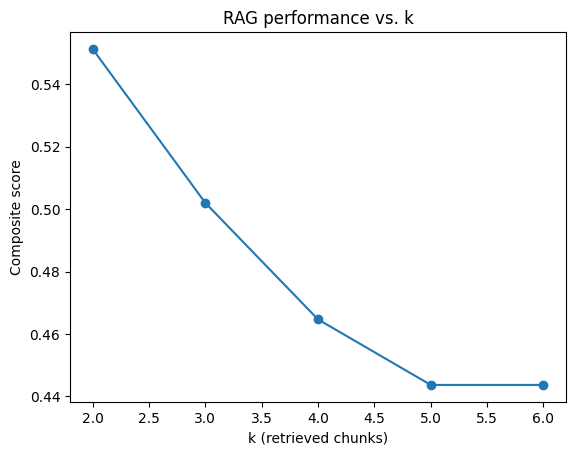

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_results["k"], k_results["composite"], marker="o")
plt.xlabel("k (retrieved chunks)")
plt.ylabel("Composite score")
plt.title("RAG performance vs. k")
plt.show()

## Part 10: Error Analysis  
Low-scoring examples are isolated to examine common failure modes.  
This helps determine whether errors are caused by weak retrieval, inaccurate generation, or both.

In [17]:
# Part 10: Minimal error analysis

def find_bad_cases(results, top_n=3):
    rows = []
    for r in results:
        rows.append({
            "question": r.question,
            "answer": r.answer,
            "reference": r.reference_answer,
            "retrieved_doc_ids": ", ".join(r.retrieved_docs),
            **r.metrics
        })
    df = pd.DataFrame(rows)

    # Low reference similarity (accuracy-ish)
    worst_ref = df.sort_values("answer_reference_sim").head(top_n)

    # Low context similarity (faithfulness-ish)
    worst_ctx = df.sort_values("answer_context_sim").head(top_n)

    # Low retrieval precision (retriever miss)
    worst_rp = df.sort_values("retrieval_precision_at_k").head(top_n)

    return {
        "low_ref_similarity": worst_ref,
        "low_context_similarity": worst_ctx,
        "low_retrieval_precision": worst_rp
    }

analysis = find_bad_cases(results, top_n=2)
analysis["low_ref_similarity"], analysis["low_context_similarity"], analysis["low_retrieval_precision"]

(                                            question  \
 3  Give one Responsible AI practice related to no...   
 4  Name some common OneNote productivity tips the...   
 
                                               answer  \
 3           [kb_004 • Data Privacy & Responsible AI]   
 4  adding headings, creating checklists, and inse...   
 
                                            reference  \
 3  Enforce tenant boundaries and role-based acces...   
 4  Use keyboard shortcuts, add headings, create c...   
 
                 retrieved_doc_ids  retrieval_precision_at_k  \
 3  kb_004, kb_001, kb_005, kb_002                      0.50   
 4  kb_005, kb_001, kb_003, kb_004                      0.25   
 
    answer_reference_sim  answer_context_sim  idk_flag  
 3              0.393782            0.522337       0.0  
 4              0.687125            0.261576       0.0  ,
                                             question  \
 4  Name some common OneNote productivity tips the...   
 

In [18]:
# Save everything to compare future runs
metrics_df.to_csv("eval_run_metrics.csv", index=False)
k_results.to_csv("eval_k_sweep.csv", index=False)

# Also save raw Q/A with contexts for manual review
pd.DataFrame([{
    "question": r.question,
    "answer": r.answer,
    "reference": r.reference_answer,
    "retrieved_doc_ids": ", ".join(r.retrieved_docs),
    "context": r.ctx_text
} for r in results]).to_csv("eval_run_qa_context.csv", index=False)

print("Saved: eval_run_metrics.csv, eval_k_sweep.csv, eval_run_qa_context.csv")

Saved: eval_run_metrics.csv, eval_k_sweep.csv, eval_run_qa_context.csv


## Part 11: Regression Guard  
Current results are compared to a saved baseline to detect performance regressions.  
This ensures future changes do not unintentionally reduce quality.

In [19]:
# Part 11: Regression guard (optional)
import os

BASELINE_CSV = "baseline_eval_run_metrics.csv"

def load_csv_safe(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

current = metrics_df.copy()
baseline = load_csv_safe(BASELINE_CSV)

if baseline is None:
    print("No baseline found. Saving current metrics as baseline for future comparisons.")
    current.to_csv(BASELINE_CSV, index=False)
else:
    # Compare aggregates + simple tolerance
    cur_agg = aggregate_metrics(current)
    base_agg = aggregate_metrics(baseline)
    delta = (cur_agg - base_agg).round(4)
    print("=== Regression Check vs Baseline ===")
    print("Current:", cur_agg.round(4).to_dict())
    print("Baseline:", base_agg.round(4).to_dict())
    print("Delta:", delta.to_dict())

    # Fail if we regress hard on key axes
    FAIL = (
        delta["avg_answer_reference_sim"] < -0.05 or
        delta["avg_answer_context_sim"]   < -0.05 or
        delta["avg_retrieval_precision_at_k"] < -0.10
    )
    print("\nResult:", "FAIL (significant regression)" if FAIL else "PASS (no significant regression)")

=== Regression Check vs Baseline ===
Current: {'avg_retrieval_precision_at_k': 0.3, 'avg_answer_reference_sim': 0.7065, 'avg_answer_context_sim': 0.4496, 'idk_rate': 0.0}
Baseline: {'avg_retrieval_precision_at_k': 0.3, 'avg_answer_reference_sim': 0.7065, 'avg_answer_context_sim': 0.4496, 'idk_rate': 0.0}
Delta: {'avg_retrieval_precision_at_k': 0.0, 'avg_answer_reference_sim': 0.0, 'avg_answer_context_sim': 0.0, 'idk_rate': 0.0}

Result: PASS (no significant regression)


## Part 12: Keyword Overlap Metric  
A keyword overlap score is added to measure how many words in the model’s answer also appear in the reference.  
This helps evaluate short, fact-based questions where specific terminology is important.

In [20]:
# Part 12: Lightweight exact/keyword match
from collections import Counter

def normalize_text(s: str) -> list:
    toks = re.findall(r"[a-z0-9]+", s.lower())
    return toks

def keyword_overlap_score(answer: str, reference: str) -> float:
    a, r = Counter(normalize_text(answer)), Counter(normalize_text(reference))
    common = sum((a & r).values())
    total = max(1, sum(r.values()))
    return common / total

# Attach to table
metrics_df["answer_keyword_overlap"] = [
    keyword_overlap_score(r.answer, r.reference_answer) for r in results
]
metrics_df

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_flag,answer_keyword_overlap
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.715593,0.605258,0.0,0.840000
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.928162,0.502279,0.0,0.650000
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.807727,0.356393,0.0,0.666667
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.393782,0.522337,0.0,0.066667
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.687125,0.261576,0.0,0.312500


## Part 13: Threshold Flags  
Threshold-based rules are applied to automatically flag weak answers.  
Flags highlight low reference similarity, low faithfulness, low retrieval precision, or missing key terms.

In [21]:
# Part 13: Thresholded flags
THRESH_RELEVANCE   = 0.60   # similarity to reference
THRESH_FAITHFUL    = 0.55   # similarity to context
THRESH_RETRIEVAL   = 0.50   # precision@k
THRESH_KEYWORD     = 0.35   # overlap proxy

def flag_row(row):
    flags = []
    if row["answer_reference_sim"] < THRESH_RELEVANCE:
        flags.append("low_ref_sim")
    if row["answer_context_sim"] < THRESH_FAITHFUL:
        flags.append("low_ctx_sim")
    if row["retrieval_precision_at_k"] < THRESH_RETRIEVAL:
        flags.append("low_retrieval")
    if row.get("idk_flag", 0) == 1.0:
        flags.append("idk")
    if row.get("answer_keyword_overlap", 1.0) < THRESH_KEYWORD:
        flags.append("low_keyword_overlap")
    return ", ".join(flags)

metrics_df["flags"] = metrics_df.apply(flag_row, axis=1)
metrics_df

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_flag,answer_keyword_overlap,flags
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.715593,0.605258,0.0,0.840000,low_retrieval
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.928162,0.502279,0.0,0.650000,"low_ctx_sim, low_retrieval"
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.807727,0.356393,0.0,0.666667,"low_ctx_sim, low_retrieval"
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.393782,0.522337,0.0,0.066667,"low_ref_sim, low_ctx_sim, low_keyword_overlap"
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.687125,0.261576,0.0,0.312500,"low_ctx_sim, low_retrieval, low_keyword_overlap"


## Part 14: Summary Table  
A summary table is generated showing each question, retrieved documents, all metric scores, and any flags.  
This provides a clear, scannable view of the system’s performance.

In [22]:
# Part 14: Compact display + top issues
display_cols = [
    "question",
    "retrieved_doc_ids",
    "retrieval_precision_at_k",
    "answer_reference_sim",
    "answer_context_sim",
    "answer_keyword_overlap",
    "idk_flag",
    "flags"
]
pretty_df = metrics_df[display_cols].copy().round({
    "retrieval_precision_at_k": 2,
    "answer_reference_sim": 2,
    "answer_context_sim": 2,
    "answer_keyword_overlap": 2
})
pretty_df

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,answer_keyword_overlap,idk_flag,flags
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.72,0.61,0.84,0.0,low_retrieval
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.93,0.50,0.65,0.0,"low_ctx_sim, low_retrieval"
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.81,0.36,0.67,0.0,"low_ctx_sim, low_retrieval"
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.39,0.52,0.07,0.0,"low_ref_sim, low_ctx_sim, low_keyword_overlap"
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.69,0.26,0.31,0.0,"low_ctx_sim, low_retrieval, low_keyword_overlap"


In [23]:
# Quick sanity checks
print("Index size:", index.ntotal)
print("k_results rows:", len(k_results))
print("metrics_df shape:", metrics_df.shape)

# No FAISS pad IDs should sneak through now
test = retrieve("sanity check", k=999)
assert all("doc_id" in r for r in test), "Retriever returned malformed rows"
print("Retriever OK ✅")

# Show the summary table head
pretty_df.head(10)



Index size: 5
k_results rows: 5
metrics_df shape: (5, 8)
Retriever OK ✅


,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,answer_keyword_overlap,idk_flag,flags
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.72,0.61,0.84,0.0,low_retrieval
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.93,0.50,0.65,0.0,"low_ctx_sim, low_retrieval"
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.81,0.36,0.67,0.0,"low_ctx_sim, low_retrieval"
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.39,0.52,0.07,0.0,"low_ref_sim, low_ctx_sim, low_keyword_overlap"
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.69,0.26,0.31,0.0,"low_ctx_sim, low_retrieval, low_keyword_overlap"


## Part 15: Export for Submission  
Results and a README file are exported using a consistent naming convention.  
This produces a clean, portable package for submission as part of a job application or project review.

In [24]:
# Part 15: Export with naming convention

# 🔁 EDIT THESE FOR THE SPECIFIC APPLICATION
YOUR_LAST = "cford"
ROLE = "data_scientist_ii"          # e.g., "data_scientist_ii"
COMPANY = "microsoft_m365_core"     # e.g., "microsoft_m365_core"
TAG = "rag_eval_worksample"

prefix = f"{YOUR_LAST}_{ROLE}_{COMPANY}_{TAG}"

# 1) Save CSVs
metrics_path = f"{prefix}_metrics.csv"
k_path = f"{prefix}_k_sweep.csv"
qa_ctx_path = f"{prefix}_qa_context.csv"

pretty_df.to_csv(metrics_path, index=False)
k_results.to_csv(k_path, index=False)
pd.DataFrame([{
    "question": r.question,
    "answer": r.answer,
    "reference": r.reference_answer,
    "retrieved_doc_ids": ", ".join(r.retrieved_docs),
    "context": r.ctx_text
} for r in results]).to_csv(qa_ctx_path, index=False)

# 2) Autogenerate a concise README.md
readme_path = f"{prefix}_README.md"
readme = f"""# RAG Mini-Harness – Work Sample

**Candidate:** Crystal Ford
**Role Target:** {ROLE.replace('_',' ').title()}
**Company/Team:** {COMPANY.replace('_',' ').title()}

## What this shows
- Tiny domain KB ➜ embeddings (MiniLM) ➜ FAISS cosine retrieval ➜ FLAN-T5 generation
- Lightweight evaluation on Relevance, Faithfulness, Helpfulness proxies
- k-sweep to choose retrieval depth; regression guard; exact-match proxy

## TL;DR Results
- See `{metrics_path}` for per-question metrics and flags
- See `{k_path}` for retrieval depth sensitivity
- See `{qa_ctx_path}` for raw Q/A + contexts
- Composite score and aggregates are printed in the notebook (Parts 8–10)

## How to run
1. `pip install -U sentence-transformers faiss-cpu transformers accelerate torch`
2. Run notebook cells Parts 1–15 in order (Colab-safe).
3. Artifacts emit with prefix `{prefix}`.

## Notes
- Deterministic generation (beam search, no sampling) for fair eval.
- Threshold flags surface likely misses (retriever vs generator).
- Clear separation between retrieval and generation for swap-ability.
"""
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(readme)

print("Saved files:")
print("-", metrics_path)
print("-", k_path)
print("-", qa_ctx_path)
print("-", readme_path)

Saved files:
- cford_data_scientist_ii_microsoft_m365_core_rag_eval_worksample_metrics.csv
- cford_data_scientist_ii_microsoft_m365_core_rag_eval_worksample_k_sweep.csv
- cford_data_scientist_ii_microsoft_m365_core_rag_eval_worksample_qa_context.csv
- cford_data_scientist_ii_microsoft_m365_core_rag_eval_worksample_README.md
